In [52]:
import torch
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from collections import *
from PIL import Image

In [54]:
!ls resource

1538557576uQj843kE.jpg    image2.jpg                style3.jpg
cropped-colorpastel4a.jpg style1.webp               style4.jpg
image1.jpg                style2.jpg


In [77]:
style = Image.open('resource/cropped-colorpastel4a.jpg')
content = Image.open('resource/image1.jpg')

trfms = [
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
]

for f in trfms:
    content = f(content)
    style = f(style)

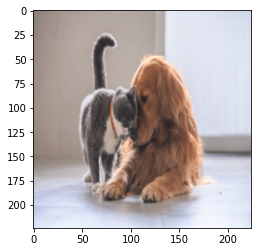

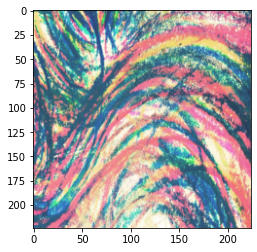

In [78]:
content = transforms.ToTensor()(transforms.ToPILImage()(content).convert("RGB"))
style = transforms.ToTensor()(transforms.ToPILImage()(style).convert("RGB"))
plt.imshow(transforms.ToPILImage()(content))
plt.show()
plt.imshow(transforms.ToPILImage()(style))
plt.show()

In [79]:
content = content.view(1, 3, 224, 224)
style = style.view(1, 3, 224, 224)

cnn = torchvision.models.vgg19(pretrained=True).features

In [80]:
class ContentLoss(torch.nn.Module):
    
    def __init__(self, target, weight):
        super(ContentLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.criterion = torch.nn.MSELoss()

    def forward(self, image):
        self.loss = self.criterion.forward(image * self.weight, self.target)
        self.output = image
        return self.output

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss


class GramMatrix(torch.nn.Module):
    
    def forward(self, image):
        a, b, c, d = image.size()
        features = image.view(a * b, c * d)
        G = torch.mm(features, features.t())
        out_1 = G.div(a * b * c * d)
        return out_1
    
#         a, b, c, d = image.size()
        
#         results = []
        
#         for i in range(b):
#             for j in range(b):
#                 ch1 = image[0][i]
#                 ch2 = image[0][j]
#                 res = (ch1 * ch2).sum()
#                 results.append(res)
        
        
#         out_2 = torch.stack(results).view(b, b) / (a * b * c * d)
        
#         print('Diff:', (out_1 - out_2).sum())
#         print('OUT_1:', out_1)
#         print('OUT_2:', out_2)
#         return out_1


class StyleLoss(torch.nn.Module):
    
    def __init__(self, target, weight):
        super(StyleLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.gram = GramMatrix()
        self.criterion = torch.nn.MSELoss()

    def forward(self, image):
        self.output = image.clone()
        self.G = self.gram.forward(image)
        self.G.mul_(self.weight)
        self.loss = self.criterion.forward(self.G, self.target)
        return self.output

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss
    

class TransferNet(torch.nn.Module):
    
    CONTENT_LAYERS = ['conv_4']
    STYLE_LAYERS = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
        
    def __init__(self, content, style, model, content_weight, style_weight):
        super(TransferNet, self).__init__()
        
        self.image = content.clone()
        self.content = content
        self.style = style
        self.model = torch.nn.Sequential()
        self.style_losses = []
        self.content_losses = []
        self.gram = GramMatrix()

        i = 1
        for layer in list(model):
            if isinstance(layer, torch.nn.Conv2d):
                name = "conv_" + str(i)
                self.model.add_module(name, layer)

                if name in self.CONTENT_LAYERS:
                    target = self.model.forward(self.content).clone()
                    content_loss = ContentLoss(target, content_weight)
                    self.model.add_module("content_loss_" + str(i), content_loss)
                    self.content_losses.append(content_loss)

                if name in self.STYLE_LAYERS:
                    target_feature = self.model.forward(self.style).clone()
                    target_feature_gram = self.gram.forward(target_feature)
                    style_loss = StyleLoss(target_feature_gram, style_weight)
                    self.model.add_module("style_loss_" + str(i), style_loss)
                    self.style_losses.append(style_loss)

            if isinstance(layer, torch.nn.ReLU):
                name = "relu_" + str(i)
                self.model.add_module(name, layer)
                i += 1

            if isinstance(layer, torch.nn.MaxPool2d):
                name = "pool_" + str(i)
                self.model.add_module(name, layer)
                        
        
    def fit(self, epoches):
        
        image = torch.nn.Parameter(self.image.data)
        optimizer = torch.optim.Adam([image], lr=0.03)
        
        for epoch in range(epoches):
        
            def closure():
                image.data.clamp_(0, 1)

                optimizer.zero_grad()
                self.model.forward(image)

                style_score = 0
                content_score = 0

                for sl in self.style_losses:
                    style_score += sl.backward()

                for cl in self.content_losses:
                    content_score += cl.backward()
                    
                loss = content_score + style_score
                print(loss)
                return loss

            optimizer.step(closure)
            
            if epoch != 0 and epoch % 20 == 0:
                plt.imshow(transforms.ToPILImage()(image.squeeze()))
                plt.show()

In [81]:
net = TransferNet(content, style, cnn, 1, 1000)
print(net)

TransferNet(
  (model): Sequential(
    (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (style_loss_1): StyleLoss(
      (gram): GramMatrix()
      (criterion): MSELoss()
    )
    (relu_1): ReLU(inplace=True)
    (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (style_loss_2): StyleLoss(
      (gram): GramMatrix()
      (criterion): MSELoss()
    )
    (relu_2): ReLU(inplace=True)
    (pool_3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (style_loss_3): StyleLoss(
      (gram): GramMatrix()
      (criterion): MSELoss()
    )
    (relu_3): ReLU(inplace=True)
    (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (content_loss_4): ContentLoss(
      (criterion): MSELoss()
    )
    (style_loss_4): StyleLoss(
      (gram): GramMatrix()
      (criterion): MSELoss()
    )
    (relu_4)

tensor(2410.3879, grad_fn=<AddBackward0>)
tensor(1842.7822, grad_fn=<AddBackward0>)
tensor(1024.5204, grad_fn=<AddBackward0>)
tensor(668.5989, grad_fn=<AddBackward0>)
tensor(492.0610, grad_fn=<AddBackward0>)
tensor(337.7525, grad_fn=<AddBackward0>)
tensor(221.4455, grad_fn=<AddBackward0>)
tensor(165.3754, grad_fn=<AddBackward0>)
tensor(143.5689, grad_fn=<AddBackward0>)
tensor(130.5695, grad_fn=<AddBackward0>)
tensor(119.3125, grad_fn=<AddBackward0>)
tensor(108.9623, grad_fn=<AddBackward0>)
tensor(100.3061, grad_fn=<AddBackward0>)
tensor(91.2102, grad_fn=<AddBackward0>)
tensor(81.1542, grad_fn=<AddBackward0>)
tensor(72.5420, grad_fn=<AddBackward0>)
tensor(65.9735, grad_fn=<AddBackward0>)
tensor(60.6792, grad_fn=<AddBackward0>)
tensor(56.2967, grad_fn=<AddBackward0>)
tensor(52.6419, grad_fn=<AddBackward0>)
tensor(49.7141, grad_fn=<AddBackward0>)


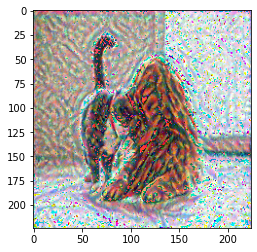

tensor(47.3338, grad_fn=<AddBackward0>)
tensor(44.7295, grad_fn=<AddBackward0>)
tensor(42.0216, grad_fn=<AddBackward0>)
tensor(39.7707, grad_fn=<AddBackward0>)
tensor(37.9574, grad_fn=<AddBackward0>)
tensor(36.3216, grad_fn=<AddBackward0>)
tensor(34.6465, grad_fn=<AddBackward0>)
tensor(33.0329, grad_fn=<AddBackward0>)
tensor(31.6517, grad_fn=<AddBackward0>)
tensor(30.3205, grad_fn=<AddBackward0>)
tensor(28.9574, grad_fn=<AddBackward0>)
tensor(27.6820, grad_fn=<AddBackward0>)
tensor(26.5293, grad_fn=<AddBackward0>)
tensor(25.4704, grad_fn=<AddBackward0>)
tensor(24.4435, grad_fn=<AddBackward0>)
tensor(23.4968, grad_fn=<AddBackward0>)
tensor(22.6897, grad_fn=<AddBackward0>)
tensor(21.9241, grad_fn=<AddBackward0>)
tensor(21.1735, grad_fn=<AddBackward0>)
tensor(20.4715, grad_fn=<AddBackward0>)


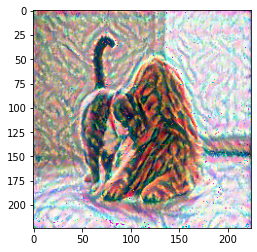

tensor(19.8434, grad_fn=<AddBackward0>)
tensor(19.2711, grad_fn=<AddBackward0>)
tensor(18.7202, grad_fn=<AddBackward0>)
tensor(18.2190, grad_fn=<AddBackward0>)
tensor(17.7618, grad_fn=<AddBackward0>)
tensor(17.3228, grad_fn=<AddBackward0>)
tensor(16.9012, grad_fn=<AddBackward0>)
tensor(16.5141, grad_fn=<AddBackward0>)
tensor(16.1700, grad_fn=<AddBackward0>)
tensor(15.8395, grad_fn=<AddBackward0>)
tensor(15.5243, grad_fn=<AddBackward0>)
tensor(15.2347, grad_fn=<AddBackward0>)
tensor(14.9678, grad_fn=<AddBackward0>)
tensor(14.7133, grad_fn=<AddBackward0>)
tensor(14.4707, grad_fn=<AddBackward0>)
tensor(14.2468, grad_fn=<AddBackward0>)
tensor(14.0346, grad_fn=<AddBackward0>)
tensor(13.8335, grad_fn=<AddBackward0>)
tensor(13.6458, grad_fn=<AddBackward0>)
tensor(13.4710, grad_fn=<AddBackward0>)


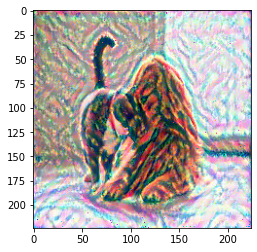

tensor(13.3007, grad_fn=<AddBackward0>)
tensor(13.1385, grad_fn=<AddBackward0>)
tensor(12.9878, grad_fn=<AddBackward0>)
tensor(12.8448, grad_fn=<AddBackward0>)
tensor(12.7073, grad_fn=<AddBackward0>)
tensor(12.5771, grad_fn=<AddBackward0>)
tensor(12.4542, grad_fn=<AddBackward0>)
tensor(12.3352, grad_fn=<AddBackward0>)
tensor(12.2218, grad_fn=<AddBackward0>)
tensor(12.1142, grad_fn=<AddBackward0>)
tensor(12.0112, grad_fn=<AddBackward0>)
tensor(11.9116, grad_fn=<AddBackward0>)
tensor(11.8167, grad_fn=<AddBackward0>)
tensor(11.7255, grad_fn=<AddBackward0>)
tensor(11.6376, grad_fn=<AddBackward0>)
tensor(11.5530, grad_fn=<AddBackward0>)
tensor(11.4722, grad_fn=<AddBackward0>)
tensor(11.3937, grad_fn=<AddBackward0>)
tensor(11.3179, grad_fn=<AddBackward0>)
tensor(11.2452, grad_fn=<AddBackward0>)


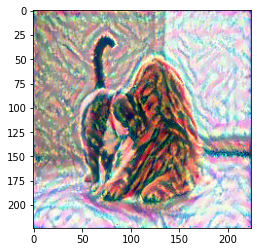

tensor(11.1751, grad_fn=<AddBackward0>)
tensor(11.1070, grad_fn=<AddBackward0>)
tensor(11.0415, grad_fn=<AddBackward0>)
tensor(10.9783, grad_fn=<AddBackward0>)
tensor(10.9171, grad_fn=<AddBackward0>)
tensor(10.8579, grad_fn=<AddBackward0>)
tensor(10.8007, grad_fn=<AddBackward0>)
tensor(10.7449, grad_fn=<AddBackward0>)
tensor(10.6910, grad_fn=<AddBackward0>)
tensor(10.6388, grad_fn=<AddBackward0>)
tensor(10.5880, grad_fn=<AddBackward0>)
tensor(10.5385, grad_fn=<AddBackward0>)
tensor(10.4905, grad_fn=<AddBackward0>)
tensor(10.4438, grad_fn=<AddBackward0>)
tensor(10.3984, grad_fn=<AddBackward0>)
tensor(10.3542, grad_fn=<AddBackward0>)
tensor(10.3111, grad_fn=<AddBackward0>)
tensor(10.2692, grad_fn=<AddBackward0>)
tensor(10.2283, grad_fn=<AddBackward0>)
tensor(10.1885, grad_fn=<AddBackward0>)


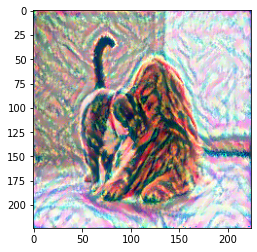

tensor(10.1495, grad_fn=<AddBackward0>)
tensor(10.1115, grad_fn=<AddBackward0>)
tensor(10.0745, grad_fn=<AddBackward0>)
tensor(10.0383, grad_fn=<AddBackward0>)
tensor(10.0029, grad_fn=<AddBackward0>)
tensor(9.9684, grad_fn=<AddBackward0>)
tensor(9.9346, grad_fn=<AddBackward0>)
tensor(9.9015, grad_fn=<AddBackward0>)
tensor(9.8692, grad_fn=<AddBackward0>)
tensor(9.8375, grad_fn=<AddBackward0>)
tensor(9.8065, grad_fn=<AddBackward0>)
tensor(9.7762, grad_fn=<AddBackward0>)
tensor(9.7465, grad_fn=<AddBackward0>)
tensor(9.7174, grad_fn=<AddBackward0>)
tensor(9.6889, grad_fn=<AddBackward0>)
tensor(9.6609, grad_fn=<AddBackward0>)
tensor(9.6335, grad_fn=<AddBackward0>)
tensor(9.6066, grad_fn=<AddBackward0>)
tensor(9.5802, grad_fn=<AddBackward0>)
tensor(9.5543, grad_fn=<AddBackward0>)


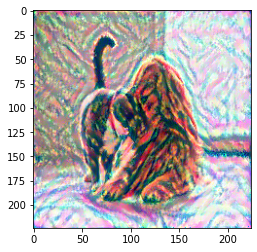

tensor(9.5289, grad_fn=<AddBackward0>)
tensor(9.5039, grad_fn=<AddBackward0>)
tensor(9.4794, grad_fn=<AddBackward0>)
tensor(9.4554, grad_fn=<AddBackward0>)
tensor(9.4317, grad_fn=<AddBackward0>)
tensor(9.4085, grad_fn=<AddBackward0>)
tensor(9.3856, grad_fn=<AddBackward0>)
tensor(9.3631, grad_fn=<AddBackward0>)
tensor(9.3410, grad_fn=<AddBackward0>)
tensor(9.3193, grad_fn=<AddBackward0>)
tensor(9.2980, grad_fn=<AddBackward0>)
tensor(9.2770, grad_fn=<AddBackward0>)
tensor(9.2563, grad_fn=<AddBackward0>)
tensor(9.2359, grad_fn=<AddBackward0>)
tensor(9.2159, grad_fn=<AddBackward0>)
tensor(9.1961, grad_fn=<AddBackward0>)
tensor(9.1766, grad_fn=<AddBackward0>)
tensor(9.1575, grad_fn=<AddBackward0>)
tensor(9.1387, grad_fn=<AddBackward0>)
tensor(9.1201, grad_fn=<AddBackward0>)


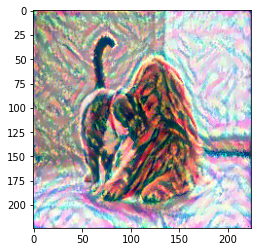

tensor(9.1018, grad_fn=<AddBackward0>)
tensor(9.0838, grad_fn=<AddBackward0>)
tensor(9.0661, grad_fn=<AddBackward0>)
tensor(9.0486, grad_fn=<AddBackward0>)
tensor(9.0314, grad_fn=<AddBackward0>)
tensor(9.0144, grad_fn=<AddBackward0>)
tensor(8.9977, grad_fn=<AddBackward0>)
tensor(8.9812, grad_fn=<AddBackward0>)
tensor(8.9649, grad_fn=<AddBackward0>)
tensor(8.9488, grad_fn=<AddBackward0>)
tensor(8.9330, grad_fn=<AddBackward0>)
tensor(8.9174, grad_fn=<AddBackward0>)
tensor(8.9020, grad_fn=<AddBackward0>)
tensor(8.8867, grad_fn=<AddBackward0>)
tensor(8.8717, grad_fn=<AddBackward0>)
tensor(8.8569, grad_fn=<AddBackward0>)
tensor(8.8423, grad_fn=<AddBackward0>)
tensor(8.8279, grad_fn=<AddBackward0>)
tensor(8.8136, grad_fn=<AddBackward0>)
tensor(8.7995, grad_fn=<AddBackward0>)


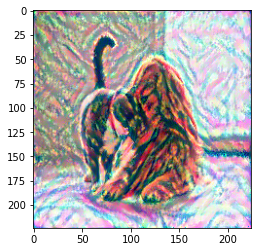

tensor(8.7856, grad_fn=<AddBackward0>)
tensor(8.7719, grad_fn=<AddBackward0>)
tensor(8.7584, grad_fn=<AddBackward0>)
tensor(8.7450, grad_fn=<AddBackward0>)
tensor(8.7317, grad_fn=<AddBackward0>)
tensor(8.7187, grad_fn=<AddBackward0>)
tensor(8.7058, grad_fn=<AddBackward0>)
tensor(8.6930, grad_fn=<AddBackward0>)
tensor(8.6804, grad_fn=<AddBackward0>)
tensor(8.6680, grad_fn=<AddBackward0>)
tensor(8.6557, grad_fn=<AddBackward0>)
tensor(8.6435, grad_fn=<AddBackward0>)
tensor(8.6315, grad_fn=<AddBackward0>)
tensor(8.6197, grad_fn=<AddBackward0>)
tensor(8.6079, grad_fn=<AddBackward0>)
tensor(8.5963, grad_fn=<AddBackward0>)
tensor(8.5849, grad_fn=<AddBackward0>)
tensor(8.5735, grad_fn=<AddBackward0>)
tensor(8.5623, grad_fn=<AddBackward0>)
tensor(8.5511, grad_fn=<AddBackward0>)


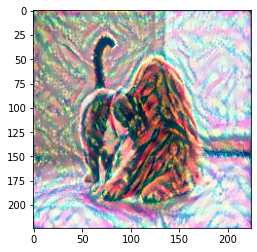

tensor(8.5401, grad_fn=<AddBackward0>)
tensor(8.5292, grad_fn=<AddBackward0>)
tensor(8.5185, grad_fn=<AddBackward0>)
tensor(8.5078, grad_fn=<AddBackward0>)
tensor(8.4972, grad_fn=<AddBackward0>)
tensor(8.4867, grad_fn=<AddBackward0>)
tensor(8.4764, grad_fn=<AddBackward0>)
tensor(8.4661, grad_fn=<AddBackward0>)
tensor(8.4559, grad_fn=<AddBackward0>)
tensor(8.4459, grad_fn=<AddBackward0>)
tensor(8.4359, grad_fn=<AddBackward0>)
tensor(8.4261, grad_fn=<AddBackward0>)
tensor(8.4163, grad_fn=<AddBackward0>)
tensor(8.4066, grad_fn=<AddBackward0>)
tensor(8.3970, grad_fn=<AddBackward0>)
tensor(8.3875, grad_fn=<AddBackward0>)
tensor(8.3781, grad_fn=<AddBackward0>)
tensor(8.3688, grad_fn=<AddBackward0>)
tensor(8.3596, grad_fn=<AddBackward0>)
tensor(8.3504, grad_fn=<AddBackward0>)


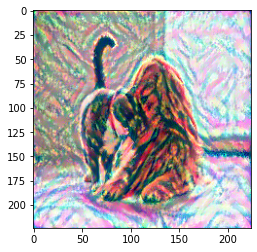

tensor(8.3414, grad_fn=<AddBackward0>)
tensor(8.3324, grad_fn=<AddBackward0>)
tensor(8.3235, grad_fn=<AddBackward0>)
tensor(8.3147, grad_fn=<AddBackward0>)
tensor(8.3059, grad_fn=<AddBackward0>)
tensor(8.2973, grad_fn=<AddBackward0>)
tensor(8.2887, grad_fn=<AddBackward0>)
tensor(8.2802, grad_fn=<AddBackward0>)
tensor(8.2718, grad_fn=<AddBackward0>)
tensor(8.2634, grad_fn=<AddBackward0>)
tensor(8.2551, grad_fn=<AddBackward0>)
tensor(8.2469, grad_fn=<AddBackward0>)
tensor(8.2388, grad_fn=<AddBackward0>)
tensor(8.2307, grad_fn=<AddBackward0>)
tensor(8.2228, grad_fn=<AddBackward0>)
tensor(8.2149, grad_fn=<AddBackward0>)
tensor(8.2070, grad_fn=<AddBackward0>)
tensor(8.1992, grad_fn=<AddBackward0>)
tensor(8.1915, grad_fn=<AddBackward0>)
tensor(8.1839, grad_fn=<AddBackward0>)


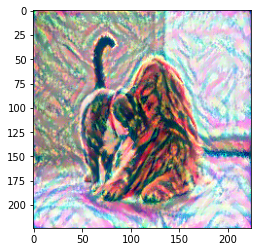

tensor(8.1763, grad_fn=<AddBackward0>)
tensor(8.1688, grad_fn=<AddBackward0>)
tensor(8.1614, grad_fn=<AddBackward0>)
tensor(8.1540, grad_fn=<AddBackward0>)
tensor(8.1467, grad_fn=<AddBackward0>)
tensor(8.1394, grad_fn=<AddBackward0>)
tensor(8.1322, grad_fn=<AddBackward0>)
tensor(8.1251, grad_fn=<AddBackward0>)
tensor(8.1180, grad_fn=<AddBackward0>)
tensor(8.1110, grad_fn=<AddBackward0>)
tensor(8.1040, grad_fn=<AddBackward0>)
tensor(8.0971, grad_fn=<AddBackward0>)
tensor(8.0903, grad_fn=<AddBackward0>)
tensor(8.0835, grad_fn=<AddBackward0>)
tensor(8.0767, grad_fn=<AddBackward0>)
tensor(8.0700, grad_fn=<AddBackward0>)
tensor(8.0634, grad_fn=<AddBackward0>)
tensor(8.0568, grad_fn=<AddBackward0>)
tensor(8.0503, grad_fn=<AddBackward0>)
tensor(8.0438, grad_fn=<AddBackward0>)


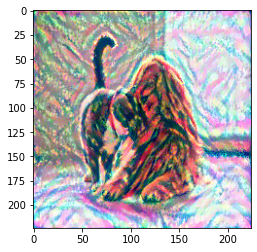

tensor(8.0374, grad_fn=<AddBackward0>)
tensor(8.0311, grad_fn=<AddBackward0>)
tensor(8.0247, grad_fn=<AddBackward0>)
tensor(8.0185, grad_fn=<AddBackward0>)
tensor(8.0123, grad_fn=<AddBackward0>)
tensor(8.0061, grad_fn=<AddBackward0>)
tensor(7.9999, grad_fn=<AddBackward0>)
tensor(7.9939, grad_fn=<AddBackward0>)
tensor(7.9878, grad_fn=<AddBackward0>)
tensor(7.9818, grad_fn=<AddBackward0>)
tensor(7.9759, grad_fn=<AddBackward0>)
tensor(7.9700, grad_fn=<AddBackward0>)
tensor(7.9641, grad_fn=<AddBackward0>)
tensor(7.9583, grad_fn=<AddBackward0>)
tensor(7.9525, grad_fn=<AddBackward0>)
tensor(7.9468, grad_fn=<AddBackward0>)
tensor(7.9411, grad_fn=<AddBackward0>)
tensor(7.9355, grad_fn=<AddBackward0>)
tensor(7.9299, grad_fn=<AddBackward0>)
tensor(7.9243, grad_fn=<AddBackward0>)


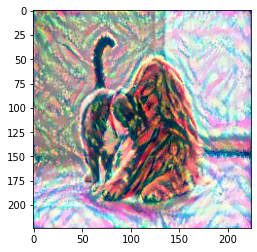

tensor(7.9188, grad_fn=<AddBackward0>)
tensor(7.9133, grad_fn=<AddBackward0>)
tensor(7.9078, grad_fn=<AddBackward0>)
tensor(7.9024, grad_fn=<AddBackward0>)
tensor(7.8970, grad_fn=<AddBackward0>)
tensor(7.8917, grad_fn=<AddBackward0>)
tensor(7.8864, grad_fn=<AddBackward0>)
tensor(7.8812, grad_fn=<AddBackward0>)
tensor(7.8759, grad_fn=<AddBackward0>)
tensor(7.8708, grad_fn=<AddBackward0>)
tensor(7.8656, grad_fn=<AddBackward0>)
tensor(7.8605, grad_fn=<AddBackward0>)
tensor(7.8554, grad_fn=<AddBackward0>)
tensor(7.8504, grad_fn=<AddBackward0>)
tensor(7.8454, grad_fn=<AddBackward0>)
tensor(7.8404, grad_fn=<AddBackward0>)
tensor(7.8354, grad_fn=<AddBackward0>)
tensor(7.8305, grad_fn=<AddBackward0>)
tensor(7.8257, grad_fn=<AddBackward0>)
tensor(7.8208, grad_fn=<AddBackward0>)


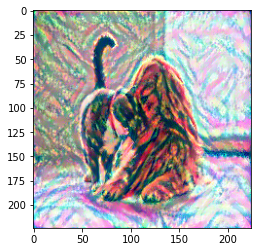

tensor(7.8160, grad_fn=<AddBackward0>)
tensor(7.8113, grad_fn=<AddBackward0>)
tensor(7.8065, grad_fn=<AddBackward0>)
tensor(7.8018, grad_fn=<AddBackward0>)
tensor(7.7972, grad_fn=<AddBackward0>)
tensor(7.7925, grad_fn=<AddBackward0>)
tensor(7.7879, grad_fn=<AddBackward0>)
tensor(7.7833, grad_fn=<AddBackward0>)
tensor(7.7788, grad_fn=<AddBackward0>)
tensor(7.7743, grad_fn=<AddBackward0>)
tensor(7.7698, grad_fn=<AddBackward0>)
tensor(7.7654, grad_fn=<AddBackward0>)
tensor(7.7609, grad_fn=<AddBackward0>)
tensor(7.7565, grad_fn=<AddBackward0>)
tensor(7.7522, grad_fn=<AddBackward0>)
tensor(7.7479, grad_fn=<AddBackward0>)
tensor(7.7437, grad_fn=<AddBackward0>)
tensor(7.7395, grad_fn=<AddBackward0>)
tensor(7.7355, grad_fn=<AddBackward0>)
tensor(7.7318, grad_fn=<AddBackward0>)


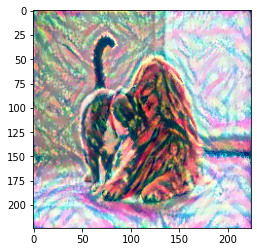

tensor(7.7284, grad_fn=<AddBackward0>)
tensor(7.7257, grad_fn=<AddBackward0>)
tensor(7.7243, grad_fn=<AddBackward0>)
tensor(7.7247, grad_fn=<AddBackward0>)
tensor(7.7286, grad_fn=<AddBackward0>)
tensor(7.7382, grad_fn=<AddBackward0>)
tensor(7.7583, grad_fn=<AddBackward0>)
tensor(7.7940, grad_fn=<AddBackward0>)
tensor(7.8595, grad_fn=<AddBackward0>)
tensor(7.9590, grad_fn=<AddBackward0>)
tensor(8.1204, grad_fn=<AddBackward0>)
tensor(8.2947, grad_fn=<AddBackward0>)
tensor(8.4915, grad_fn=<AddBackward0>)
tensor(8.4824, grad_fn=<AddBackward0>)
tensor(8.3160, grad_fn=<AddBackward0>)
tensor(7.9516, grad_fn=<AddBackward0>)
tensor(7.6999, grad_fn=<AddBackward0>)
tensor(7.7172, grad_fn=<AddBackward0>)
tensor(7.8907, grad_fn=<AddBackward0>)
tensor(7.9834, grad_fn=<AddBackward0>)


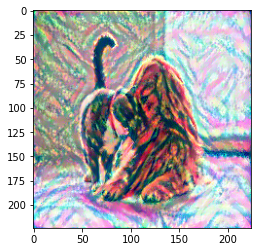

tensor(7.8741, grad_fn=<AddBackward0>)
tensor(7.7113, grad_fn=<AddBackward0>)
tensor(7.6654, grad_fn=<AddBackward0>)
tensor(7.7466, grad_fn=<AddBackward0>)
tensor(7.8078, grad_fn=<AddBackward0>)
tensor(7.7548, grad_fn=<AddBackward0>)
tensor(7.6680, grad_fn=<AddBackward0>)
tensor(7.6491, grad_fn=<AddBackward0>)
tensor(7.6940, grad_fn=<AddBackward0>)
tensor(7.7162, grad_fn=<AddBackward0>)
tensor(7.6777, grad_fn=<AddBackward0>)
tensor(7.6333, grad_fn=<AddBackward0>)
tensor(7.6329, grad_fn=<AddBackward0>)
tensor(7.6572, grad_fn=<AddBackward0>)
tensor(7.6588, grad_fn=<AddBackward0>)
tensor(7.6312, grad_fn=<AddBackward0>)
tensor(7.6093, grad_fn=<AddBackward0>)
tensor(7.6128, grad_fn=<AddBackward0>)
tensor(7.6239, grad_fn=<AddBackward0>)
tensor(7.6197, grad_fn=<AddBackward0>)


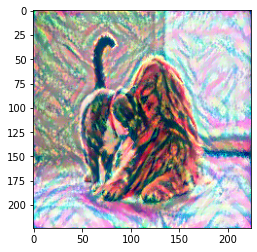

tensor(7.6020, grad_fn=<AddBackward0>)
tensor(7.5891, grad_fn=<AddBackward0>)
tensor(7.5895, grad_fn=<AddBackward0>)
tensor(7.5942, grad_fn=<AddBackward0>)
tensor(7.5914, grad_fn=<AddBackward0>)
tensor(7.5808, grad_fn=<AddBackward0>)
tensor(7.5706, grad_fn=<AddBackward0>)
tensor(7.5667, grad_fn=<AddBackward0>)
tensor(7.5674, grad_fn=<AddBackward0>)
tensor(7.5671, grad_fn=<AddBackward0>)
tensor(7.5625, grad_fn=<AddBackward0>)
tensor(7.5551, grad_fn=<AddBackward0>)
tensor(7.5482, grad_fn=<AddBackward0>)
tensor(7.5442, grad_fn=<AddBackward0>)
tensor(7.5425, grad_fn=<AddBackward0>)
tensor(7.5412, grad_fn=<AddBackward0>)
tensor(7.5389, grad_fn=<AddBackward0>)
tensor(7.5350, grad_fn=<AddBackward0>)
tensor(7.5301, grad_fn=<AddBackward0>)
tensor(7.5251, grad_fn=<AddBackward0>)


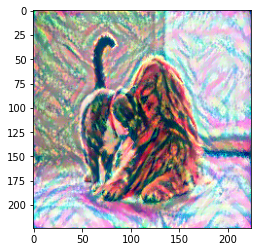

tensor(7.5205, grad_fn=<AddBackward0>)
tensor(7.5167, grad_fn=<AddBackward0>)
tensor(7.5136, grad_fn=<AddBackward0>)
tensor(7.5110, grad_fn=<AddBackward0>)
tensor(7.5087, grad_fn=<AddBackward0>)
tensor(7.5064, grad_fn=<AddBackward0>)
tensor(7.5043, grad_fn=<AddBackward0>)
tensor(7.5022, grad_fn=<AddBackward0>)
tensor(7.5005, grad_fn=<AddBackward0>)
tensor(7.4993, grad_fn=<AddBackward0>)
tensor(7.4989, grad_fn=<AddBackward0>)
tensor(7.5001, grad_fn=<AddBackward0>)
tensor(7.5033, grad_fn=<AddBackward0>)
tensor(7.5108, grad_fn=<AddBackward0>)
tensor(7.5237, grad_fn=<AddBackward0>)
tensor(7.5473, grad_fn=<AddBackward0>)
tensor(7.5850, grad_fn=<AddBackward0>)
tensor(7.6502, grad_fn=<AddBackward0>)
tensor(7.7442, grad_fn=<AddBackward0>)
tensor(7.8946, grad_fn=<AddBackward0>)


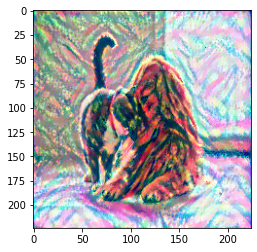

tensor(8.0565, grad_fn=<AddBackward0>)
tensor(8.2512, grad_fn=<AddBackward0>)
tensor(8.2929, grad_fn=<AddBackward0>)
tensor(8.2173, grad_fn=<AddBackward0>)
tensor(7.8990, grad_fn=<AddBackward0>)
tensor(7.5899, grad_fn=<AddBackward0>)
tensor(7.4547, grad_fn=<AddBackward0>)
tensor(7.5468, grad_fn=<AddBackward0>)
tensor(7.7174, grad_fn=<AddBackward0>)
tensor(7.7734, grad_fn=<AddBackward0>)
tensor(7.6913, grad_fn=<AddBackward0>)
tensor(7.5307, grad_fn=<AddBackward0>)
tensor(7.4471, grad_fn=<AddBackward0>)
tensor(7.4878, grad_fn=<AddBackward0>)
tensor(7.5664, grad_fn=<AddBackward0>)
tensor(7.5849, grad_fn=<AddBackward0>)
tensor(7.5211, grad_fn=<AddBackward0>)
tensor(7.4498, grad_fn=<AddBackward0>)
tensor(7.4361, grad_fn=<AddBackward0>)
tensor(7.4727, grad_fn=<AddBackward0>)


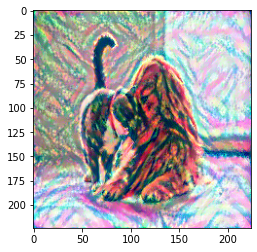

tensor(7.4999, grad_fn=<AddBackward0>)
tensor(7.4811, grad_fn=<AddBackward0>)
tensor(7.4400, grad_fn=<AddBackward0>)
tensor(7.4174, grad_fn=<AddBackward0>)
tensor(7.4277, grad_fn=<AddBackward0>)
tensor(7.4463, grad_fn=<AddBackward0>)
tensor(7.4453, grad_fn=<AddBackward0>)
tensor(7.4253, grad_fn=<AddBackward0>)
tensor(7.4051, grad_fn=<AddBackward0>)
tensor(7.4005, grad_fn=<AddBackward0>)
tensor(7.4083, grad_fn=<AddBackward0>)
tensor(7.4132, grad_fn=<AddBackward0>)
tensor(7.4076, grad_fn=<AddBackward0>)
tensor(7.3949, grad_fn=<AddBackward0>)
tensor(7.3847, grad_fn=<AddBackward0>)
tensor(7.3821, grad_fn=<AddBackward0>)
tensor(7.3846, grad_fn=<AddBackward0>)
tensor(7.3864, grad_fn=<AddBackward0>)
tensor(7.3837, grad_fn=<AddBackward0>)
tensor(7.3773, grad_fn=<AddBackward0>)


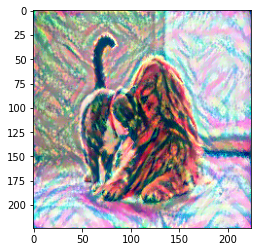

tensor(7.3698, grad_fn=<AddBackward0>)
tensor(7.3641, grad_fn=<AddBackward0>)
tensor(7.3613, grad_fn=<AddBackward0>)
tensor(7.3607, grad_fn=<AddBackward0>)
tensor(7.3605, grad_fn=<AddBackward0>)
tensor(7.3596, grad_fn=<AddBackward0>)
tensor(7.3575, grad_fn=<AddBackward0>)
tensor(7.3543, grad_fn=<AddBackward0>)
tensor(7.3504, grad_fn=<AddBackward0>)
tensor(7.3462, grad_fn=<AddBackward0>)
tensor(7.3422, grad_fn=<AddBackward0>)
tensor(7.3385, grad_fn=<AddBackward0>)
tensor(7.3352, grad_fn=<AddBackward0>)
tensor(7.3322, grad_fn=<AddBackward0>)
tensor(7.3296, grad_fn=<AddBackward0>)
tensor(7.3272, grad_fn=<AddBackward0>)
tensor(7.3250, grad_fn=<AddBackward0>)
tensor(7.3230, grad_fn=<AddBackward0>)
tensor(7.3213, grad_fn=<AddBackward0>)
tensor(7.3204, grad_fn=<AddBackward0>)


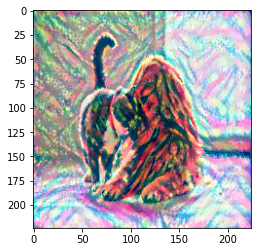

tensor(7.3210, grad_fn=<AddBackward0>)
tensor(7.3250, grad_fn=<AddBackward0>)
tensor(7.3361, grad_fn=<AddBackward0>)
tensor(7.3641, grad_fn=<AddBackward0>)
tensor(7.4274, grad_fn=<AddBackward0>)
tensor(7.5756, grad_fn=<AddBackward0>)
tensor(7.8728, grad_fn=<AddBackward0>)
tensor(8.5134, grad_fn=<AddBackward0>)
tensor(9.3649, grad_fn=<AddBackward0>)
tensor(10.5686, grad_fn=<AddBackward0>)
tensor(10.3710, grad_fn=<AddBackward0>)
tensor(9.3073, grad_fn=<AddBackward0>)
tensor(7.6192, grad_fn=<AddBackward0>)
tensor(7.5072, grad_fn=<AddBackward0>)
tensor(8.5376, grad_fn=<AddBackward0>)
tensor(8.7578, grad_fn=<AddBackward0>)
tensor(8.0434, grad_fn=<AddBackward0>)
tensor(7.3829, grad_fn=<AddBackward0>)
tensor(7.7087, grad_fn=<AddBackward0>)
tensor(8.1881, grad_fn=<AddBackward0>)


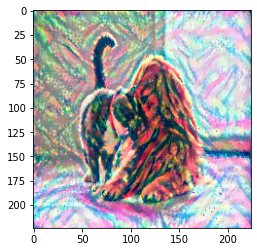

tensor(7.8534, grad_fn=<AddBackward0>)
tensor(7.4058, grad_fn=<AddBackward0>)
tensor(7.5471, grad_fn=<AddBackward0>)
tensor(7.8229, grad_fn=<AddBackward0>)
tensor(7.6812, grad_fn=<AddBackward0>)
tensor(7.3986, grad_fn=<AddBackward0>)
tensor(7.4727, grad_fn=<AddBackward0>)
tensor(7.6470, grad_fn=<AddBackward0>)
tensor(7.5381, grad_fn=<AddBackward0>)
tensor(7.3787, grad_fn=<AddBackward0>)
tensor(7.4316, grad_fn=<AddBackward0>)
tensor(7.5196, grad_fn=<AddBackward0>)
tensor(7.4487, grad_fn=<AddBackward0>)
tensor(7.3555, grad_fn=<AddBackward0>)
tensor(7.3959, grad_fn=<AddBackward0>)
tensor(7.4451, grad_fn=<AddBackward0>)
tensor(7.3857, grad_fn=<AddBackward0>)
tensor(7.3341, grad_fn=<AddBackward0>)
tensor(7.3675, grad_fn=<AddBackward0>)
tensor(7.3862, grad_fn=<AddBackward0>)


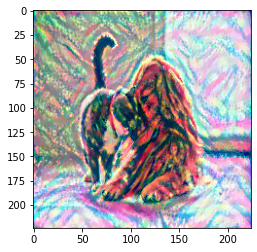

tensor(7.3426, grad_fn=<AddBackward0>)
tensor(7.3162, grad_fn=<AddBackward0>)
tensor(7.3383, grad_fn=<AddBackward0>)
tensor(7.3437, grad_fn=<AddBackward0>)
tensor(7.3135, grad_fn=<AddBackward0>)
tensor(7.2992, grad_fn=<AddBackward0>)
tensor(7.3113, grad_fn=<AddBackward0>)
tensor(7.3116, grad_fn=<AddBackward0>)
tensor(7.2927, grad_fn=<AddBackward0>)
tensor(7.2816, grad_fn=<AddBackward0>)
tensor(7.2863, grad_fn=<AddBackward0>)
tensor(7.2877, grad_fn=<AddBackward0>)
tensor(7.2760, grad_fn=<AddBackward0>)
tensor(7.2650, grad_fn=<AddBackward0>)
tensor(7.2650, grad_fn=<AddBackward0>)
tensor(7.2672, grad_fn=<AddBackward0>)
tensor(7.2611, grad_fn=<AddBackward0>)
tensor(7.2513, grad_fn=<AddBackward0>)
tensor(7.2474, grad_fn=<AddBackward0>)
tensor(7.2482, grad_fn=<AddBackward0>)


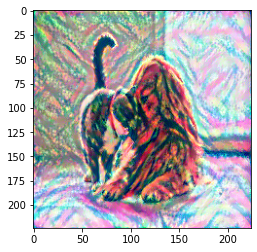

tensor(7.2460, grad_fn=<AddBackward0>)
tensor(7.2398, grad_fn=<AddBackward0>)
tensor(7.2339, grad_fn=<AddBackward0>)
tensor(7.2313, grad_fn=<AddBackward0>)
tensor(7.2304, grad_fn=<AddBackward0>)
tensor(7.2281, grad_fn=<AddBackward0>)
tensor(7.2238, grad_fn=<AddBackward0>)
tensor(7.2189, grad_fn=<AddBackward0>)
tensor(7.2156, grad_fn=<AddBackward0>)
tensor(7.2139, grad_fn=<AddBackward0>)
tensor(7.2122, grad_fn=<AddBackward0>)
tensor(7.2093, grad_fn=<AddBackward0>)
tensor(7.2057, grad_fn=<AddBackward0>)
tensor(7.2022, grad_fn=<AddBackward0>)
tensor(7.1993, grad_fn=<AddBackward0>)
tensor(7.1971, grad_fn=<AddBackward0>)
tensor(7.1952, grad_fn=<AddBackward0>)
tensor(7.1930, grad_fn=<AddBackward0>)
tensor(7.1904, grad_fn=<AddBackward0>)
tensor(7.1875, grad_fn=<AddBackward0>)


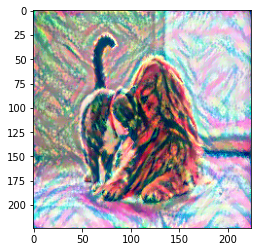

tensor(7.1846, grad_fn=<AddBackward0>)
tensor(7.1819, grad_fn=<AddBackward0>)
tensor(7.1795, grad_fn=<AddBackward0>)
tensor(7.1773, grad_fn=<AddBackward0>)
tensor(7.1753, grad_fn=<AddBackward0>)
tensor(7.1732, grad_fn=<AddBackward0>)
tensor(7.1712, grad_fn=<AddBackward0>)
tensor(7.1691, grad_fn=<AddBackward0>)
tensor(7.1669, grad_fn=<AddBackward0>)
tensor(7.1648, grad_fn=<AddBackward0>)
tensor(7.1627, grad_fn=<AddBackward0>)
tensor(7.1607, grad_fn=<AddBackward0>)
tensor(7.1587, grad_fn=<AddBackward0>)
tensor(7.1568, grad_fn=<AddBackward0>)
tensor(7.1551, grad_fn=<AddBackward0>)
tensor(7.1537, grad_fn=<AddBackward0>)
tensor(7.1526, grad_fn=<AddBackward0>)
tensor(7.1521, grad_fn=<AddBackward0>)
tensor(7.1525, grad_fn=<AddBackward0>)
tensor(7.1547, grad_fn=<AddBackward0>)


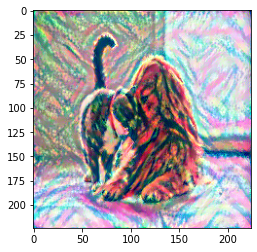

tensor(7.1594, grad_fn=<AddBackward0>)
tensor(7.1691, grad_fn=<AddBackward0>)
tensor(7.1872, grad_fn=<AddBackward0>)
tensor(7.2214, grad_fn=<AddBackward0>)
tensor(7.2788, grad_fn=<AddBackward0>)
tensor(7.3815, grad_fn=<AddBackward0>)
tensor(7.5293, grad_fn=<AddBackward0>)
tensor(7.7618, grad_fn=<AddBackward0>)
tensor(7.9731, grad_fn=<AddBackward0>)
tensor(8.1827, grad_fn=<AddBackward0>)
tensor(8.0697, grad_fn=<AddBackward0>)
tensor(7.7638, grad_fn=<AddBackward0>)
tensor(7.3279, grad_fn=<AddBackward0>)
tensor(7.1344, grad_fn=<AddBackward0>)
tensor(7.2521, grad_fn=<AddBackward0>)
tensor(7.4722, grad_fn=<AddBackward0>)
tensor(7.5768, grad_fn=<AddBackward0>)
tensor(7.4483, grad_fn=<AddBackward0>)
tensor(7.2383, grad_fn=<AddBackward0>)
tensor(7.1340, grad_fn=<AddBackward0>)


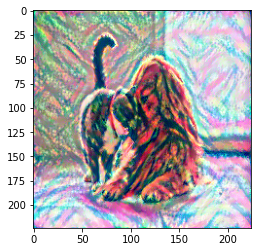

tensor(7.2067, grad_fn=<AddBackward0>)
tensor(7.3189, grad_fn=<AddBackward0>)
tensor(7.3156, grad_fn=<AddBackward0>)
tensor(7.2187, grad_fn=<AddBackward0>)
tensor(7.1354, grad_fn=<AddBackward0>)
tensor(7.1475, grad_fn=<AddBackward0>)
tensor(7.2076, grad_fn=<AddBackward0>)
tensor(7.2214, grad_fn=<AddBackward0>)
tensor(7.1767, grad_fn=<AddBackward0>)
tensor(7.1270, grad_fn=<AddBackward0>)
tensor(7.1243, grad_fn=<AddBackward0>)
tensor(7.1539, grad_fn=<AddBackward0>)
tensor(7.1657, grad_fn=<AddBackward0>)
tensor(7.1445, grad_fn=<AddBackward0>)
tensor(7.1151, grad_fn=<AddBackward0>)
tensor(7.1077, grad_fn=<AddBackward0>)
tensor(7.1209, grad_fn=<AddBackward0>)
tensor(7.1298, grad_fn=<AddBackward0>)
tensor(7.1215, grad_fn=<AddBackward0>)
tensor(7.1044, grad_fn=<AddBackward0>)


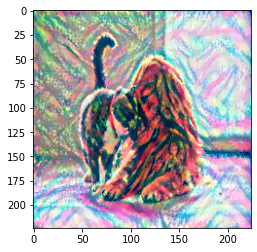

tensor(7.0949, grad_fn=<AddBackward0>)
tensor(7.0976, grad_fn=<AddBackward0>)
tensor(7.1034, grad_fn=<AddBackward0>)
tensor(7.1032, grad_fn=<AddBackward0>)
tensor(7.0954, grad_fn=<AddBackward0>)
tensor(7.0864, grad_fn=<AddBackward0>)
tensor(7.0816, grad_fn=<AddBackward0>)
tensor(7.0820, grad_fn=<AddBackward0>)
tensor(7.0841, grad_fn=<AddBackward0>)
tensor(7.0838, grad_fn=<AddBackward0>)
tensor(7.0802, grad_fn=<AddBackward0>)
tensor(7.0747, grad_fn=<AddBackward0>)
tensor(7.0698, grad_fn=<AddBackward0>)
tensor(7.0670, grad_fn=<AddBackward0>)
tensor(7.0662, grad_fn=<AddBackward0>)
tensor(7.0662, grad_fn=<AddBackward0>)
tensor(7.0658, grad_fn=<AddBackward0>)
tensor(7.0647, grad_fn=<AddBackward0>)
tensor(7.0627, grad_fn=<AddBackward0>)
tensor(7.0602, grad_fn=<AddBackward0>)


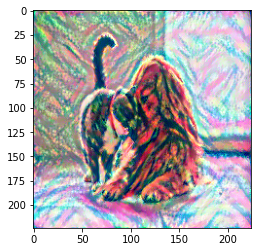

tensor(7.0573, grad_fn=<AddBackward0>)
tensor(7.0544, grad_fn=<AddBackward0>)
tensor(7.0516, grad_fn=<AddBackward0>)
tensor(7.0491, grad_fn=<AddBackward0>)
tensor(7.0470, grad_fn=<AddBackward0>)
tensor(7.0450, grad_fn=<AddBackward0>)
tensor(7.0432, grad_fn=<AddBackward0>)
tensor(7.0416, grad_fn=<AddBackward0>)
tensor(7.0401, grad_fn=<AddBackward0>)
tensor(7.0387, grad_fn=<AddBackward0>)
tensor(7.0377, grad_fn=<AddBackward0>)
tensor(7.0373, grad_fn=<AddBackward0>)
tensor(7.0384, grad_fn=<AddBackward0>)
tensor(7.0431, grad_fn=<AddBackward0>)
tensor(7.0565, grad_fn=<AddBackward0>)
tensor(7.0908, grad_fn=<AddBackward0>)
tensor(7.1790, grad_fn=<AddBackward0>)
tensor(7.3845, grad_fn=<AddBackward0>)
tensor(7.8765, grad_fn=<AddBackward0>)
tensor(8.7610, grad_fn=<AddBackward0>)


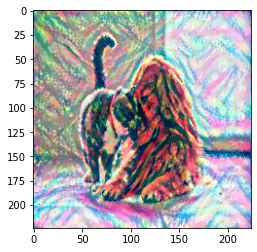

tensor(10.4066, grad_fn=<AddBackward0>)
tensor(11.3432, grad_fn=<AddBackward0>)
tensor(11.7230, grad_fn=<AddBackward0>)
tensor(9.1628, grad_fn=<AddBackward0>)
tensor(7.3195, grad_fn=<AddBackward0>)
tensor(7.4743, grad_fn=<AddBackward0>)
tensor(8.8225, grad_fn=<AddBackward0>)
tensor(9.8304, grad_fn=<AddBackward0>)
tensor(8.9764, grad_fn=<AddBackward0>)
tensor(7.7000, grad_fn=<AddBackward0>)
tensor(7.2328, grad_fn=<AddBackward0>)
tensor(7.9176, grad_fn=<AddBackward0>)
tensor(8.6520, grad_fn=<AddBackward0>)
tensor(8.3098, grad_fn=<AddBackward0>)
tensor(7.5589, grad_fn=<AddBackward0>)
tensor(7.2431, grad_fn=<AddBackward0>)
tensor(7.6078, grad_fn=<AddBackward0>)
tensor(7.9931, grad_fn=<AddBackward0>)
tensor(7.7906, grad_fn=<AddBackward0>)
tensor(7.3698, grad_fn=<AddBackward0>)


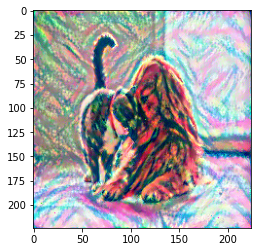

tensor(7.2343, grad_fn=<AddBackward0>)
tensor(7.4563, grad_fn=<AddBackward0>)
tensor(7.6171, grad_fn=<AddBackward0>)
tensor(7.4585, grad_fn=<AddBackward0>)
tensor(7.2439, grad_fn=<AddBackward0>)
tensor(7.2276, grad_fn=<AddBackward0>)
tensor(7.3536, grad_fn=<AddBackward0>)
tensor(7.3964, grad_fn=<AddBackward0>)
tensor(7.2815, grad_fn=<AddBackward0>)
tensor(7.1789, grad_fn=<AddBackward0>)
tensor(7.2045, grad_fn=<AddBackward0>)
tensor(7.2720, grad_fn=<AddBackward0>)
tensor(7.2641, grad_fn=<AddBackward0>)
tensor(7.1879, grad_fn=<AddBackward0>)
tensor(7.1447, grad_fn=<AddBackward0>)
tensor(7.1675, grad_fn=<AddBackward0>)
tensor(7.1965, grad_fn=<AddBackward0>)
tensor(7.1825, grad_fn=<AddBackward0>)
tensor(7.1378, grad_fn=<AddBackward0>)
tensor(7.1142, grad_fn=<AddBackward0>)


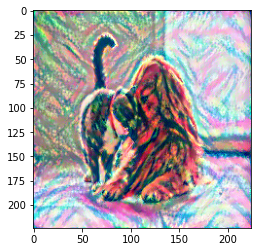

tensor(7.1277, grad_fn=<AddBackward0>)
tensor(7.1428, grad_fn=<AddBackward0>)
tensor(7.1311, grad_fn=<AddBackward0>)
tensor(7.1040, grad_fn=<AddBackward0>)
tensor(7.0890, grad_fn=<AddBackward0>)
tensor(7.0922, grad_fn=<AddBackward0>)
tensor(7.0997, grad_fn=<AddBackward0>)
tensor(7.0960, grad_fn=<AddBackward0>)
tensor(7.0799, grad_fn=<AddBackward0>)
tensor(7.0663, grad_fn=<AddBackward0>)
tensor(7.0633, grad_fn=<AddBackward0>)
tensor(7.0660, grad_fn=<AddBackward0>)
tensor(7.0663, grad_fn=<AddBackward0>)
tensor(7.0602, grad_fn=<AddBackward0>)
tensor(7.0502, grad_fn=<AddBackward0>)
tensor(7.0420, grad_fn=<AddBackward0>)
tensor(7.0390, grad_fn=<AddBackward0>)
tensor(7.0389, grad_fn=<AddBackward0>)
tensor(7.0381, grad_fn=<AddBackward0>)
tensor(7.0349, grad_fn=<AddBackward0>)


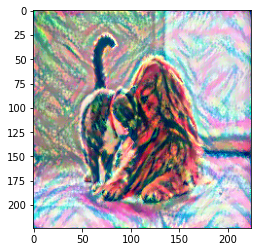

tensor(7.0293, grad_fn=<AddBackward0>)
tensor(7.0233, grad_fn=<AddBackward0>)
tensor(7.0185, grad_fn=<AddBackward0>)
tensor(7.0156, grad_fn=<AddBackward0>)
tensor(7.0139, grad_fn=<AddBackward0>)
tensor(7.0124, grad_fn=<AddBackward0>)
tensor(7.0104, grad_fn=<AddBackward0>)
tensor(7.0077, grad_fn=<AddBackward0>)
tensor(7.0042, grad_fn=<AddBackward0>)
tensor(7.0005, grad_fn=<AddBackward0>)
tensor(6.9968, grad_fn=<AddBackward0>)
tensor(6.9935, grad_fn=<AddBackward0>)
tensor(6.9906, grad_fn=<AddBackward0>)
tensor(6.9882, grad_fn=<AddBackward0>)
tensor(6.9860, grad_fn=<AddBackward0>)
tensor(6.9841, grad_fn=<AddBackward0>)
tensor(6.9823, grad_fn=<AddBackward0>)
tensor(6.9808, grad_fn=<AddBackward0>)
tensor(6.9794, grad_fn=<AddBackward0>)
tensor(6.9786, grad_fn=<AddBackward0>)


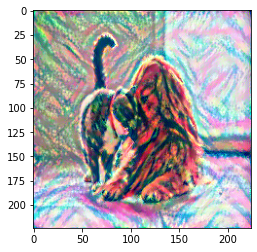

tensor(6.9784, grad_fn=<AddBackward0>)
tensor(6.9793, grad_fn=<AddBackward0>)
tensor(6.9819, grad_fn=<AddBackward0>)
tensor(6.9874, grad_fn=<AddBackward0>)
tensor(6.9969, grad_fn=<AddBackward0>)
tensor(7.0143, grad_fn=<AddBackward0>)
tensor(7.0409, grad_fn=<AddBackward0>)
tensor(7.0846, grad_fn=<AddBackward0>)
tensor(7.1456, grad_fn=<AddBackward0>)
tensor(7.2383, grad_fn=<AddBackward0>)
tensor(7.3354, grad_fn=<AddBackward0>)
tensor(7.4523, grad_fn=<AddBackward0>)
tensor(7.4911, grad_fn=<AddBackward0>)
tensor(7.4681, grad_fn=<AddBackward0>)
tensor(7.3036, grad_fn=<AddBackward0>)
tensor(7.1099, grad_fn=<AddBackward0>)
tensor(6.9703, grad_fn=<AddBackward0>)
tensor(6.9602, grad_fn=<AddBackward0>)
tensor(7.0442, grad_fn=<AddBackward0>)
tensor(7.1212, grad_fn=<AddBackward0>)


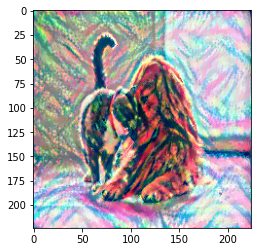

tensor(7.1324, grad_fn=<AddBackward0>)
tensor(7.0629, grad_fn=<AddBackward0>)
tensor(6.9798, grad_fn=<AddBackward0>)
tensor(6.9445, grad_fn=<AddBackward0>)
tensor(6.9705, grad_fn=<AddBackward0>)
tensor(7.0129, grad_fn=<AddBackward0>)
tensor(7.0200, grad_fn=<AddBackward0>)
tensor(6.9896, grad_fn=<AddBackward0>)
tensor(6.9505, grad_fn=<AddBackward0>)
tensor(6.9369, grad_fn=<AddBackward0>)
tensor(6.9513, grad_fn=<AddBackward0>)
tensor(6.9682, grad_fn=<AddBackward0>)
tensor(6.9672, grad_fn=<AddBackward0>)
tensor(6.9492, grad_fn=<AddBackward0>)
tensor(6.9314, grad_fn=<AddBackward0>)
tensor(6.9271, grad_fn=<AddBackward0>)
tensor(6.9342, grad_fn=<AddBackward0>)
tensor(6.9406, grad_fn=<AddBackward0>)
tensor(6.9377, grad_fn=<AddBackward0>)
tensor(6.9282, grad_fn=<AddBackward0>)


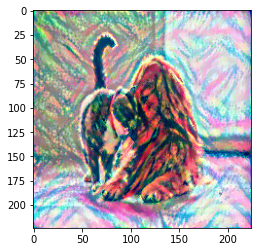

tensor(6.9192, grad_fn=<AddBackward0>)
tensor(6.9161, grad_fn=<AddBackward0>)
tensor(6.9181, grad_fn=<AddBackward0>)
tensor(6.9203, grad_fn=<AddBackward0>)
tensor(6.9195, grad_fn=<AddBackward0>)
tensor(6.9155, grad_fn=<AddBackward0>)
tensor(6.9106, grad_fn=<AddBackward0>)
tensor(6.9068, grad_fn=<AddBackward0>)
tensor(6.9051, grad_fn=<AddBackward0>)
tensor(6.9047, grad_fn=<AddBackward0>)
tensor(6.9043, grad_fn=<AddBackward0>)
tensor(6.9029, grad_fn=<AddBackward0>)
tensor(6.9006, grad_fn=<AddBackward0>)
tensor(6.8981, grad_fn=<AddBackward0>)
tensor(6.8960, grad_fn=<AddBackward0>)
tensor(6.8950, grad_fn=<AddBackward0>)
tensor(6.8950, grad_fn=<AddBackward0>)
tensor(6.8961, grad_fn=<AddBackward0>)
tensor(6.8979, grad_fn=<AddBackward0>)
tensor(6.9010, grad_fn=<AddBackward0>)


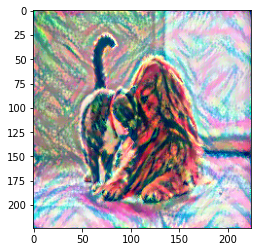

tensor(6.9060, grad_fn=<AddBackward0>)
tensor(6.9158, grad_fn=<AddBackward0>)
tensor(6.9340, grad_fn=<AddBackward0>)
tensor(6.9712, grad_fn=<AddBackward0>)
tensor(7.0410, grad_fn=<AddBackward0>)
tensor(7.1850, grad_fn=<AddBackward0>)
tensor(7.4313, grad_fn=<AddBackward0>)
tensor(7.8909, grad_fn=<AddBackward0>)
tensor(8.4200, grad_fn=<AddBackward0>)
tensor(9.1189, grad_fn=<AddBackward0>)
tensor(9.0371, grad_fn=<AddBackward0>)
tensor(8.4638, grad_fn=<AddBackward0>)
tensor(7.3660, grad_fn=<AddBackward0>)
tensor(6.9717, grad_fn=<AddBackward0>)
tensor(7.4027, grad_fn=<AddBackward0>)
tensor(7.8789, grad_fn=<AddBackward0>)
tensor(7.9237, grad_fn=<AddBackward0>)
tensor(7.4053, grad_fn=<AddBackward0>)
tensor(7.1195, grad_fn=<AddBackward0>)
tensor(7.3871, grad_fn=<AddBackward0>)


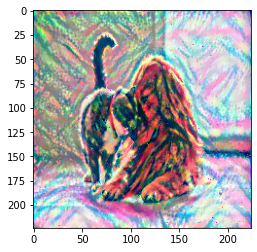

tensor(7.7612, grad_fn=<AddBackward0>)
tensor(7.7693, grad_fn=<AddBackward0>)
tensor(7.3958, grad_fn=<AddBackward0>)
tensor(7.1879, grad_fn=<AddBackward0>)
tensor(7.4097, grad_fn=<AddBackward0>)
tensor(7.5998, grad_fn=<AddBackward0>)
tensor(7.4633, grad_fn=<AddBackward0>)
tensor(7.1104, grad_fn=<AddBackward0>)
tensor(7.0443, grad_fn=<AddBackward0>)
tensor(7.1865, grad_fn=<AddBackward0>)
tensor(7.1521, grad_fn=<AddBackward0>)
tensor(7.0029, grad_fn=<AddBackward0>)
tensor(7.0163, grad_fn=<AddBackward0>)
tensor(7.1513, grad_fn=<AddBackward0>)
tensor(7.1450, grad_fn=<AddBackward0>)
tensor(7.0170, grad_fn=<AddBackward0>)
tensor(6.9792, grad_fn=<AddBackward0>)
tensor(7.0463, grad_fn=<AddBackward0>)
tensor(7.0354, grad_fn=<AddBackward0>)
tensor(6.9448, grad_fn=<AddBackward0>)


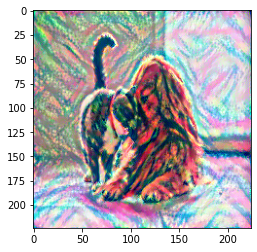

tensor(6.9200, grad_fn=<AddBackward0>)
tensor(6.9718, grad_fn=<AddBackward0>)
tensor(6.9791, grad_fn=<AddBackward0>)
tensor(6.9315, grad_fn=<AddBackward0>)
tensor(6.9234, grad_fn=<AddBackward0>)
tensor(6.9549, grad_fn=<AddBackward0>)
tensor(6.9521, grad_fn=<AddBackward0>)
tensor(6.9158, grad_fn=<AddBackward0>)
tensor(6.9052, grad_fn=<AddBackward0>)
tensor(6.9201, grad_fn=<AddBackward0>)
tensor(6.9163, grad_fn=<AddBackward0>)
tensor(6.8924, grad_fn=<AddBackward0>)
tensor(6.8839, grad_fn=<AddBackward0>)
tensor(6.8925, grad_fn=<AddBackward0>)
tensor(6.8919, grad_fn=<AddBackward0>)
tensor(6.8792, grad_fn=<AddBackward0>)
tensor(6.8732, grad_fn=<AddBackward0>)
tensor(6.8778, grad_fn=<AddBackward0>)
tensor(6.8793, grad_fn=<AddBackward0>)
tensor(6.8730, grad_fn=<AddBackward0>)


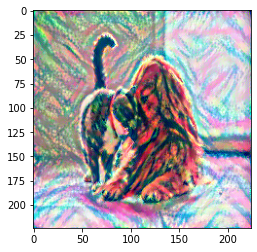

tensor(6.8681, grad_fn=<AddBackward0>)
tensor(6.8710, grad_fn=<AddBackward0>)
tensor(6.8770, grad_fn=<AddBackward0>)
tensor(6.8823, grad_fn=<AddBackward0>)
tensor(6.8900, grad_fn=<AddBackward0>)
tensor(6.9104, grad_fn=<AddBackward0>)
tensor(6.9498, grad_fn=<AddBackward0>)
tensor(7.0202, grad_fn=<AddBackward0>)
tensor(7.1203, grad_fn=<AddBackward0>)
tensor(7.2809, grad_fn=<AddBackward0>)
tensor(7.4638, grad_fn=<AddBackward0>)
tensor(7.6931, grad_fn=<AddBackward0>)
tensor(7.7609, grad_fn=<AddBackward0>)
tensor(7.7026, grad_fn=<AddBackward0>)
tensor(7.3542, grad_fn=<AddBackward0>)
tensor(7.0103, grad_fn=<AddBackward0>)
tensor(6.8467, grad_fn=<AddBackward0>)
tensor(6.9363, grad_fn=<AddBackward0>)
tensor(7.1326, grad_fn=<AddBackward0>)
tensor(7.2253, grad_fn=<AddBackward0>)


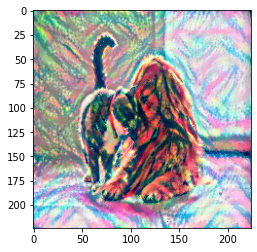

tensor(7.1715, grad_fn=<AddBackward0>)
tensor(6.9997, grad_fn=<AddBackward0>)
tensor(6.8683, grad_fn=<AddBackward0>)
tensor(6.8631, grad_fn=<AddBackward0>)
tensor(6.9482, grad_fn=<AddBackward0>)
tensor(7.0196, grad_fn=<AddBackward0>)
tensor(7.0021, grad_fn=<AddBackward0>)
tensor(6.9247, grad_fn=<AddBackward0>)
tensor(6.8538, grad_fn=<AddBackward0>)
tensor(6.8474, grad_fn=<AddBackward0>)
tensor(6.8887, grad_fn=<AddBackward0>)
tensor(6.9184, grad_fn=<AddBackward0>)
tensor(6.9075, grad_fn=<AddBackward0>)
tensor(6.8675, grad_fn=<AddBackward0>)
tensor(6.8367, grad_fn=<AddBackward0>)
tensor(6.8363, grad_fn=<AddBackward0>)
tensor(6.8547, grad_fn=<AddBackward0>)
tensor(6.8666, grad_fn=<AddBackward0>)
tensor(6.8590, grad_fn=<AddBackward0>)
tensor(6.8406, grad_fn=<AddBackward0>)


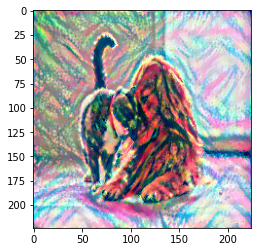

tensor(6.8259, grad_fn=<AddBackward0>)
tensor(6.8235, grad_fn=<AddBackward0>)
tensor(6.8300, grad_fn=<AddBackward0>)
tensor(6.8353, grad_fn=<AddBackward0>)
tensor(6.8336, grad_fn=<AddBackward0>)
tensor(6.8258, grad_fn=<AddBackward0>)
tensor(6.8178, grad_fn=<AddBackward0>)
tensor(6.8132, grad_fn=<AddBackward0>)
tensor(6.8122, grad_fn=<AddBackward0>)
tensor(6.8125, grad_fn=<AddBackward0>)
tensor(6.8124, grad_fn=<AddBackward0>)
tensor(6.8117, grad_fn=<AddBackward0>)
tensor(6.8104, grad_fn=<AddBackward0>)
tensor(6.8088, grad_fn=<AddBackward0>)
tensor(6.8068, grad_fn=<AddBackward0>)
tensor(6.8047, grad_fn=<AddBackward0>)
tensor(6.8021, grad_fn=<AddBackward0>)
tensor(6.7991, grad_fn=<AddBackward0>)
tensor(6.7958, grad_fn=<AddBackward0>)
tensor(6.7930, grad_fn=<AddBackward0>)


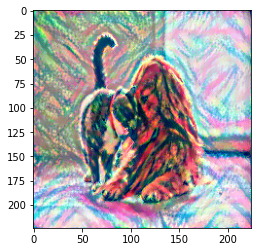

tensor(6.7909, grad_fn=<AddBackward0>)
tensor(6.7898, grad_fn=<AddBackward0>)
tensor(6.7892, grad_fn=<AddBackward0>)
tensor(6.7887, grad_fn=<AddBackward0>)
tensor(6.7884, grad_fn=<AddBackward0>)
tensor(6.7883, grad_fn=<AddBackward0>)
tensor(6.7893, grad_fn=<AddBackward0>)
tensor(6.7929, grad_fn=<AddBackward0>)
tensor(6.8035, grad_fn=<AddBackward0>)
tensor(6.8314, grad_fn=<AddBackward0>)
tensor(6.9073, grad_fn=<AddBackward0>)
tensor(7.0952, grad_fn=<AddBackward0>)
tensor(7.5715, grad_fn=<AddBackward0>)
tensor(8.5012, grad_fn=<AddBackward0>)
tensor(10.4083, grad_fn=<AddBackward0>)
tensor(11.8981, grad_fn=<AddBackward0>)
tensor(13.1245, grad_fn=<AddBackward0>)
tensor(10.4341, grad_fn=<AddBackward0>)
tensor(8.1151, grad_fn=<AddBackward0>)
tensor(7.1310, grad_fn=<AddBackward0>)


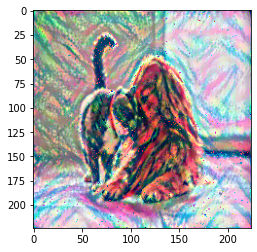

tensor(8.0945, grad_fn=<AddBackward0>)
tensor(10.6112, grad_fn=<AddBackward0>)
tensor(13.3242, grad_fn=<AddBackward0>)
tensor(16.9228, grad_fn=<AddBackward0>)
tensor(13.9350, grad_fn=<AddBackward0>)
tensor(14.2343, grad_fn=<AddBackward0>)
tensor(13.3566, grad_fn=<AddBackward0>)
tensor(14.6140, grad_fn=<AddBackward0>)
tensor(13.7821, grad_fn=<AddBackward0>)
tensor(12.0494, grad_fn=<AddBackward0>)
tensor(19.2431, grad_fn=<AddBackward0>)
tensor(26.9944, grad_fn=<AddBackward0>)
tensor(36.9505, grad_fn=<AddBackward0>)
tensor(17.3211, grad_fn=<AddBackward0>)
tensor(17.5011, grad_fn=<AddBackward0>)
tensor(20.0001, grad_fn=<AddBackward0>)
tensor(16.4427, grad_fn=<AddBackward0>)
tensor(11.9880, grad_fn=<AddBackward0>)
tensor(16.2972, grad_fn=<AddBackward0>)
tensor(32.1890, grad_fn=<AddBackward0>)


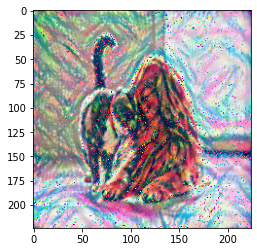

tensor(34.2550, grad_fn=<AddBackward0>)
tensor(53.1758, grad_fn=<AddBackward0>)
tensor(23.7845, grad_fn=<AddBackward0>)
tensor(14.3109, grad_fn=<AddBackward0>)
tensor(18.3194, grad_fn=<AddBackward0>)
tensor(22.4329, grad_fn=<AddBackward0>)
tensor(28.7449, grad_fn=<AddBackward0>)
tensor(23.4539, grad_fn=<AddBackward0>)
tensor(28.0175, grad_fn=<AddBackward0>)
tensor(15.0895, grad_fn=<AddBackward0>)
tensor(12.2341, grad_fn=<AddBackward0>)
tensor(17.3280, grad_fn=<AddBackward0>)
tensor(15.3412, grad_fn=<AddBackward0>)
tensor(15.8711, grad_fn=<AddBackward0>)
tensor(21.7147, grad_fn=<AddBackward0>)
tensor(32.6604, grad_fn=<AddBackward0>)
tensor(18.6253, grad_fn=<AddBackward0>)
tensor(20.0340, grad_fn=<AddBackward0>)
tensor(16.7265, grad_fn=<AddBackward0>)
tensor(11.1862, grad_fn=<AddBackward0>)


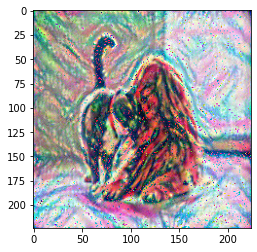

tensor(16.4283, grad_fn=<AddBackward0>)
tensor(14.2753, grad_fn=<AddBackward0>)
tensor(10.7928, grad_fn=<AddBackward0>)
tensor(13.7254, grad_fn=<AddBackward0>)
tensor(12.5336, grad_fn=<AddBackward0>)
tensor(10.0656, grad_fn=<AddBackward0>)
tensor(12.6120, grad_fn=<AddBackward0>)
tensor(10.5196, grad_fn=<AddBackward0>)
tensor(9.6342, grad_fn=<AddBackward0>)
tensor(10.8712, grad_fn=<AddBackward0>)
tensor(9.7052, grad_fn=<AddBackward0>)
tensor(9.5852, grad_fn=<AddBackward0>)
tensor(10.7284, grad_fn=<AddBackward0>)
tensor(9.9398, grad_fn=<AddBackward0>)
tensor(10.6913, grad_fn=<AddBackward0>)
tensor(10.6269, grad_fn=<AddBackward0>)
tensor(9.6903, grad_fn=<AddBackward0>)
tensor(9.1590, grad_fn=<AddBackward0>)
tensor(8.7736, grad_fn=<AddBackward0>)
tensor(8.3408, grad_fn=<AddBackward0>)


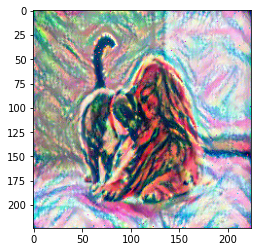

tensor(8.9236, grad_fn=<AddBackward0>)
tensor(8.9781, grad_fn=<AddBackward0>)
tensor(8.5821, grad_fn=<AddBackward0>)
tensor(8.5972, grad_fn=<AddBackward0>)
tensor(8.1124, grad_fn=<AddBackward0>)
tensor(8.1401, grad_fn=<AddBackward0>)
tensor(8.3943, grad_fn=<AddBackward0>)
tensor(8.1878, grad_fn=<AddBackward0>)
tensor(8.2052, grad_fn=<AddBackward0>)
tensor(8.0822, grad_fn=<AddBackward0>)
tensor(7.8510, grad_fn=<AddBackward0>)
tensor(7.9189, grad_fn=<AddBackward0>)
tensor(7.9295, grad_fn=<AddBackward0>)
tensor(7.8628, grad_fn=<AddBackward0>)
tensor(7.9080, grad_fn=<AddBackward0>)
tensor(7.8246, grad_fn=<AddBackward0>)
tensor(7.7135, grad_fn=<AddBackward0>)
tensor(7.7403, grad_fn=<AddBackward0>)
tensor(7.6834, grad_fn=<AddBackward0>)
tensor(7.6722, grad_fn=<AddBackward0>)


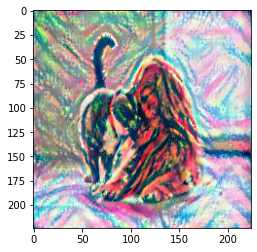

tensor(7.7207, grad_fn=<AddBackward0>)
tensor(7.6473, grad_fn=<AddBackward0>)
tensor(7.6321, grad_fn=<AddBackward0>)
tensor(7.6210, grad_fn=<AddBackward0>)
tensor(7.5474, grad_fn=<AddBackward0>)
tensor(7.5565, grad_fn=<AddBackward0>)
tensor(7.5466, grad_fn=<AddBackward0>)
tensor(7.5164, grad_fn=<AddBackward0>)
tensor(7.5344, grad_fn=<AddBackward0>)
tensor(7.5170, grad_fn=<AddBackward0>)
tensor(7.4934, grad_fn=<AddBackward0>)
tensor(7.4914, grad_fn=<AddBackward0>)
tensor(7.4671, grad_fn=<AddBackward0>)
tensor(7.4441, grad_fn=<AddBackward0>)
tensor(7.4360, grad_fn=<AddBackward0>)
tensor(7.4197, grad_fn=<AddBackward0>)
tensor(7.4022, grad_fn=<AddBackward0>)
tensor(7.3995, grad_fn=<AddBackward0>)
tensor(7.3889, grad_fn=<AddBackward0>)


In [82]:
net.fit(1000)

In [ ]:
plt.imshow(transforms.ToPILImage()(net.image.squeeze()))
plt.show()